In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import warnings
warnings.simplefilter('ignore')
from classes.text_features import TextFeatureExtractor
from dotenv import load_dotenv
from tqdm.auto import tqdm
import os
from pandas.api.types import is_numeric_dtype
import pandas as pd

load_dotenv();

In [52]:
df = pd.read_pickle(os.path.join("datasets", "final_data.pkl"))#gather_data_from_folders(playlists_dir)

In [53]:
df.shape

(5378, 572)

# Features

In [5]:
non_feature_columns = [ 'id', 'title', 'artist', 'album_art_url', 'genres', 'mp3_path', 'lyrics' ]

In [6]:
cat_features = [ f for f in df.select_dtypes(include=['category', 'object']).columns if f not in non_feature_columns ]
num_features = [ f for f in df.select_dtypes(include=['number']).columns if f not in non_feature_columns ]

In [7]:
cat_features

['key', 'mode', 'time_signature', 'language', 'genre']

In [8]:
len(num_features)

558

# Optimal Classification

In [15]:
from classes.model_pipeline import OptimalClassificationPipeline

In [16]:
target = 'mode'
cat_features = [ f for f in cat_features if f != target ]
num_features = [ f for f in num_features if f != target ]

In [32]:
df[cat_features] = df[cat_features].astype('category')

In [35]:
clf_pipeline = OptimalClassificationPipeline(
    df.dropna(subset=[target]),
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=1,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
clf_pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: mode
INFO: Setting up the pipeline...
INFO: Setting up the pipeline...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['popularity',
                                                   'album_release_year',
                                                   'duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mfcc_1', 'mfcc_2',
                                                   'm...
                                                   'mfcc_11', 'mfcc_12',
                                                   'mfcc_13', 'chroma_1',
                                                   'chroma_2', 'chroma_3',
                                                   'chroma_4', 'chroma_5', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant'))]),
                                                  ['key', 'time_signature',
                                                   'language', 'genre'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x700b14daed10>)])

In [36]:
clf_pipeline.split()
clf_pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-06 02:51:10,586] A new study created in memory with name: no-name-02a0fa3e-000e-45d3-b3a2-bcc9fbe020da
[I 2024-12-06 02:52:07,187] Trial 0 finished with value: 0.7492302277140847 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.023867971415652348, 'l2_leaf_reg': 9.009771323490268}. Best is trial 0 with value: 0.7492302277140847.


INFO: Pipeline training completed.


In [37]:
clf_pipeline.model.training_results

,Metric,Score
0,Accuracy,0.932
1,F1 Score,0.932
2,Precision,0.935
3,Recall,0.932


INFO: Evaluating the model...


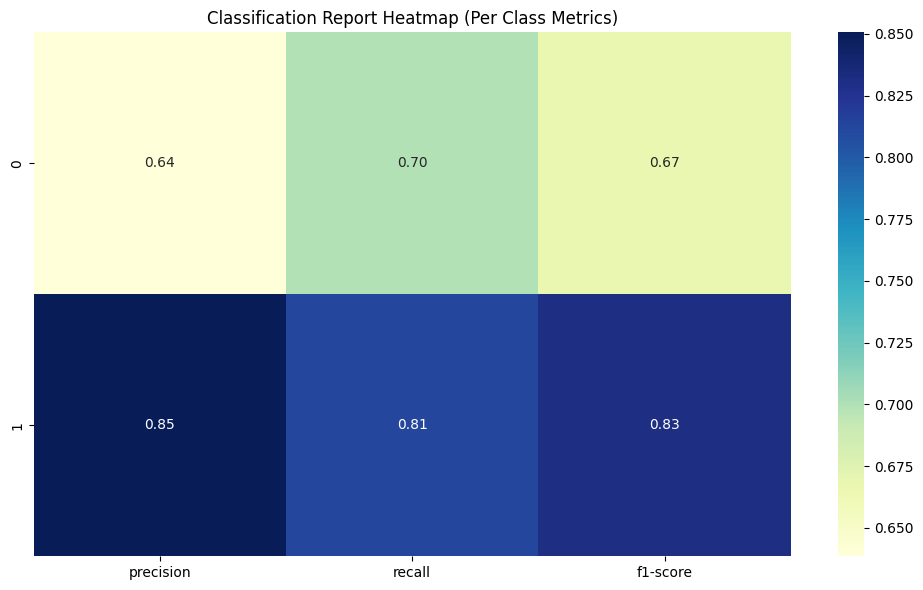

,precision,recall,f1-score,support
0,0.638522,0.699422,0.667586,346.000000
1,0.850575,0.812071,0.830877,729.000000
accuracy,0.775814,0.775814,0.775814,0.775814
macro avg,0.744549,0.755747,0.749232,1075.000000
weighted avg,0.782323,0.775814,0.778320,1075.000000


In [38]:
clf_pipeline.evaluate_model()

In [39]:
clf_pipeline.save_results(f"dashboard/results/{target}")

INFO: Saving results to dashboard/results/mode...
INFO: Saving evaluation metrics...
INFO: Evaluating the model...
INFO: Classification report heatmap saved to dashboard/results/mode/classification_report_heatmap.png
INFO: Classification report saved to dashboard/results/mode/classification_report.csv
INFO: Saving SHAP analysis results...
INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.
INFO: SHAP beeswarm plot saved to dashboard/results/mode/shap_beeswarm.png
INFO: Generating feature importance bar plot...
INFO: Feature importance bar plot saved to dashboard/results/mode/shap_feature_importance.png
INFO: All results saved successfully.


# Optimal Regression

In [40]:
from classes.model_pipeline import OptimalRegressionPipeline

In [41]:
target = 'acousticness'
cat_features = [ f for f in cat_features if f != target ]
num_features = [ f for f in num_features if f != target ]

In [43]:
reg_pipeline = OptimalRegressionPipeline(
    df.dropna(subset=['genre']),
    target_column=target,
    num_features=num_features,
    cat_features=cat_features,
    n_trials=1,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
reg_pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: acousticness
INFO: Setting up the pipeline...
INFO: Setting up the pipeline...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['popularity',
                                                                                        'album_release_year',
                                                                                        'duration_ms',
                                                                                        'danceability',
                                                                                        'energy',
                                                                                        'loudness',
                                                                                        'speechiness',
                                                                                        'instrumentalness',
                                                                                        'liveness',
                                                                                        'valence',
                                                                                        'tempo...
                                                                                        'chroma_4',
                                                                                        'chroma_5',
                                                                                        'chroma_6', ...]),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value='unknown',
                                                                                                                      strategy='constant'))]),
                                                                                       ['key',
                                                                                        'time_signature',
                                                                                        'language',
                                                                                        'genre'])],
                                                                        verbose_feature_names_out=False)),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x700b0eba99f0>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [44]:
reg_pipeline.split()
reg_pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-06 03:01:57,935] A new study created in memory with name: no-name-99768906-f7d5-4558-ada9-bb3fe8cc50d4
[I 2024-12-06 03:08:34,677] Trial 0 finished with value: -0.20812102846131092 and parameters: {'iterations': 1000, 'depth': 8, 'learning_rate': 0.01501838346718149, 'l2_leaf_reg': 3.764545455654119}. Best is trial 0 with value: -0.20812102846131092.


INFO: Pipeline training completed.


In [45]:
reg_pipeline.model.training_results

,Metric,Score
0,MAE,0.227
1,MSE,0.097
2,RMSE,0.312
3,R2,0.903


INFO: Evaluating the regression model...


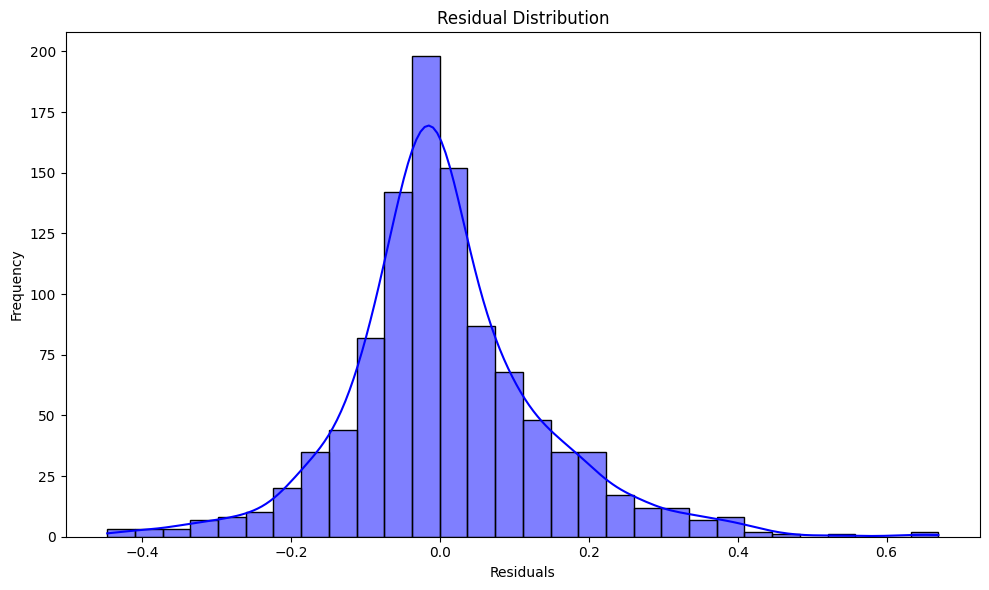

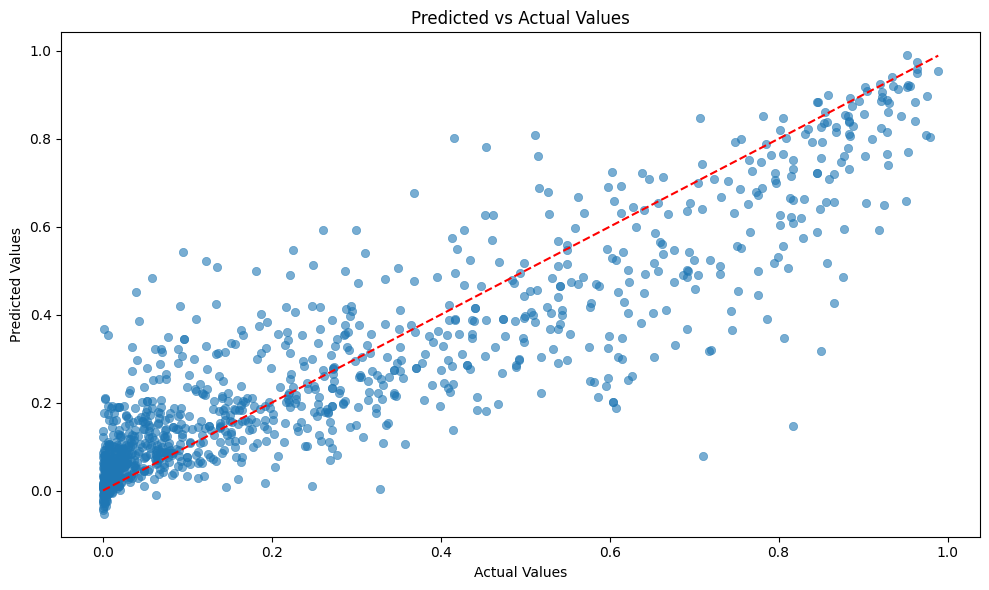

,Metric,Score
0,Mean Absolute Error,0.092953
1,Mean Squared Error,0.017288
2,Root Mean Squared Error,0.131482
3,R2 Score,0.797984


In [46]:
reg_pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


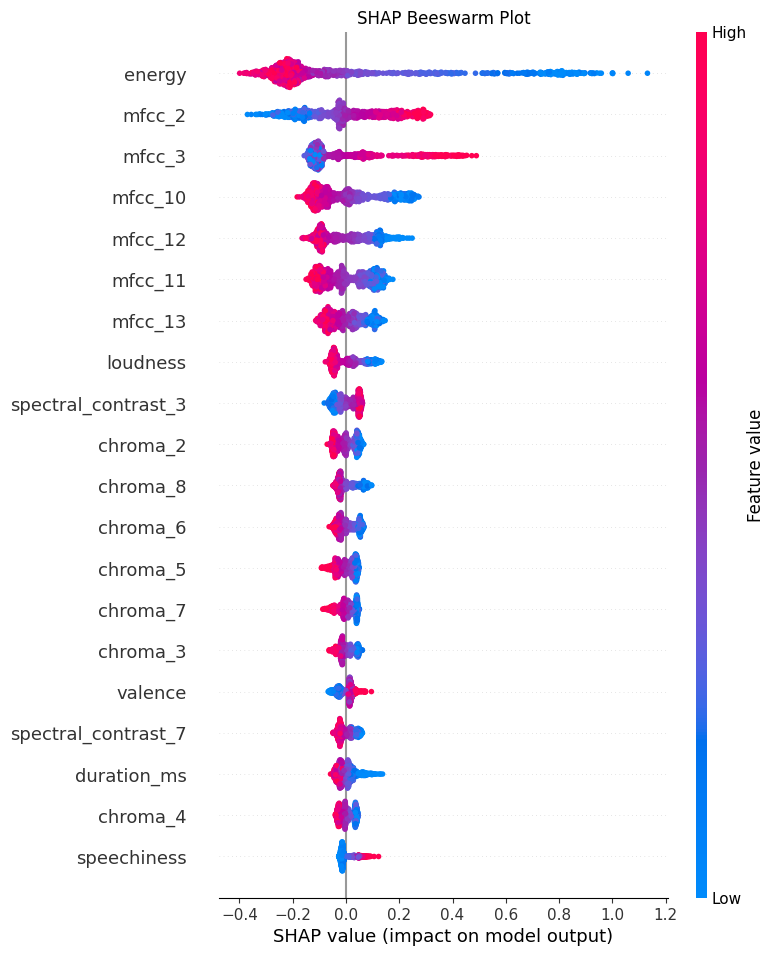

INFO: Generating feature importance bar plot...


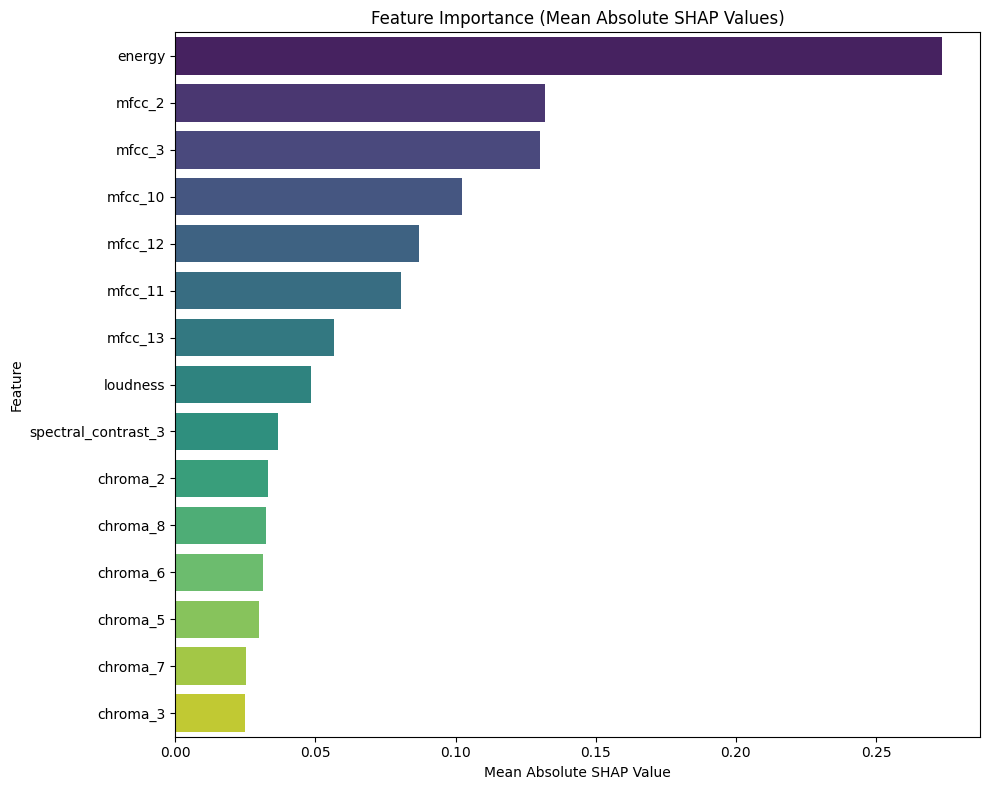

In [47]:
reg_pipeline.perform_shap_analysis()

In [48]:
reg_pipeline.save_results(f'dashboard/results/{target}')

INFO: Saving results to dashboard/results/acousticness...
INFO: Saving evaluation metrics...
INFO: Evaluating the regression model...
INFO: Residual distribution plot saved to dashboard/results/acousticness/residual_distribution.png
INFO: Predicted vs actual plot saved to dashboard/results/acousticness/predicted_vs_actual.png
INFO: Regression metrics saved to dashboard/results/acousticness/regression_metrics.csv
INFO: Saving SHAP analysis results...
INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.
INFO: SHAP beeswarm plot saved to dashboard/results/acousticness/shap_beeswarm.png
INFO: Generating feature importance bar plot...
INFO: Feature importance bar plot saved to dashboard/results/acousticness/shap_feature_importance.png
INFO: All results saved successfully.


# Automated

In [99]:
features_to_exclude = ['title', 'artist', 'mp3_path', 'lyrics']

In [100]:
features_to_predict = ['explicit',
       'album_release_year', 'duration_ms',
       'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'tempo_extracted', 'zcr']

In [115]:
df['explicit'] = df['explicit'].map({True: 1, False: 0})

In [116]:
for target in tqdm(features_to_predict):
    if os.path.exists(f"dashboard/results/{target}"):
        continue
    cat_features = [ f for f in df.select_dtypes(include=['category']).columns if f != target and f not in features_to_exclude]
    num_features = [ f for f in df.select_dtypes(include=['number']).columns if f != target and f not in features_to_exclude]

    if is_numeric_dtype(df[target]):
        model = RegressionPipeline(df, target_column=target, num_features=num_features, cat_features=cat_features)
    else:
        model = ClassificationPipeline(df, target_column=target, num_features=num_features, cat_features=cat_features)
        
    model.run_pipeline(f'dashboard/results/{target}')

  0%|          | 0/17 [00:00<?, ?it/s]

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline...


Pipeline Progress:   0%|          | 0/5 [00:00<?, ?step/s]

INFO: Starting pipeline execution...
INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Fixing class balance...
INFO: Applied SMOTE with k_neighbors=5 to fix class imbalance.
INFO: Model training completed.
INFO: Evaluating classification model...
INFO: Classification evaluation completed.
INFO: Performing SHAP analysis for classification...


 98%|===================| 2346/2400 [00:45<00:01]        

INFO: SHAP analysis for classification completed.
INFO: Saving results to dashboard/results/explicit...
INFO: Evaluating classification model...
INFO: Classification evaluation completed.
INFO: Evaluation results saved to dashboard/results/explicit/evaluation_results.csv
INFO: SHAP summary plot saved to dashboard/results/explicit/shap_summary_plot.png
INFO: SHAP beeswarm plot saved to dashboard/results/explicit/shap_beeswarm_plot.png
INFO: Pipeline execution completed.
INFO: Initializing pipeline for target variable: album_release_year
INFO: Setting up the pipeline...


Pipeline Progress:   0%|          | 0/5 [00:00<?, ?step/s]

INFO: Starting pipeline execution...
INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the model...
INFO: Model training completed.
INFO: Evaluating regression model...
INFO: Regression evaluation completed.
INFO: Performing SHAP analysis for regression...


100%|===================| 1198/1200 [01:00<00:00]        

INFO: SHAP analysis for regression completed.
INFO: Saving results to dashboard/results/album_release_year...
INFO: Evaluating regression model...
INFO: Regression evaluation completed.
INFO: Evaluation results saved to dashboard/results/album_release_year/evaluation_results.csv
INFO: SHAP summary plot saved to dashboard/results/album_release_year/shap_summary_plot.png
INFO: SHAP beeswarm plot saved to dashboard/results/album_release_year/shap_beeswarm_plot.png
INFO: Pipeline execution completed.
INFO: Initializing pipeline for target variable: duration_ms
INFO: Setting up the pipeline...


Pipeline Progress:   0%|          | 0/5 [00:00<?, ?step/s]

INFO: Starting pipeline execution...
INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the model...
INFO: Model training completed.
INFO: Evaluating regression model...
INFO: Regression evaluation completed.
INFO: Performing SHAP analysis for regression...


 99%|===================| 1187/1200 [01:18<00:00]        

INFO: SHAP analysis for regression completed.
INFO: Saving results to dashboard/results/duration_ms...
INFO: Evaluating regression model...
INFO: Regression evaluation completed.
INFO: Evaluation results saved to dashboard/results/duration_ms/evaluation_results.csv
INFO: SHAP summary plot saved to dashboard/results/duration_ms/shap_summary_plot.png
INFO: SHAP beeswarm plot saved to dashboard/results/duration_ms/shap_beeswarm_plot.png
INFO: Pipeline execution completed.
